Import & Load Data

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")

df = pd.read_csv("../data/critical_minerals_data.csv")  # adjust path if needed
df.head()

,HS_Code,Commodity_Name,Commodity,District,Year,Month,Date,Value_USD,Inflation_Rate_of_its_year,Real_Trade_Value_2015,Diff_Real_From_PrevMonth,Diff_Real_From_SameMonthPrevYear
0,2504,Natural Graphite,2504 Natural Graphite,"Anchorage, AK",2015,1,January 2015,0,0.12%,0.00,NaN,NaN
1,2504,Natural Graphite,2504 Natural Graphite,"Anchorage, AK",2015,2,February 2015,0,0.12%,0.00,0.00,NaN
2,2504,Natural Graphite,2504 Natural Graphite,"Anchorage, AK",2015,3,March 2015,0,0.12%,0.00,0.00,NaN
3,2504,Natural Graphite,2504 Natural Graphite,"Anchorage, AK",2015,4,April 2015,0,0.12%,0.00,0.00,NaN
4,2504,Natural Graphite,2504 Natural Graphite,"Anchorage, AK",2015,5,May 2015,0,0.12%,0.00,0.00,NaN


Section 1: Introduction & Data Description

1.1 Objective

This project analyzes U.S. imports of critical minerals from Canada to understand how these flows have changed over time and whether there are signs of potential supply chain issues. By looking at monthly trade values (both nominal and inflation-adjusted) across different minerals and U.S. customs districts, the goal is to spot patterns such as sudden drops, sustained declines, or abnormal volatility that might signal disruptions or vulnerabilities in the Canada–U.S. critical minerals supply chain.


1.2 Dataset Overview 

The dataset contains monthly U.S. trade data for key critical minerals, broken down by commodity, export district, and time, with both nominal and real (inflation-adjusted) values. Each row represents one HS code–district–month combination.


Section 2: Data Quality & Cleaning

In [17]:
# SECTION 2 — Data Quality & Cleaning 
import pandas as pd
import numpy as np

print("Cleaning Numeric Columns ")

# Numeric columns expected in your inflation-adjusted dataset
numeric_cols = [
    "Value_USD",
    "Real_Trade_Value_2015",
    "Diff_Real_From_PrevMonth",
    "Diff_Real_From_SameMonthPrevYear"
]

# Convert to proper numeric
for col in numeric_cols:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(",", "", regex=False)
            .str.strip()
        )
        df[col] = pd.to_numeric(df[col], errors="coerce")

print("Numeric columns cleaned.\n")


# 2.1 Missing Values
print("2.1 Missing Values ")
missing_values = df.isna().sum().sort_values(ascending=False)
print(missing_values)

# Check expected NaNs in diff columns
if "Diff_Real_From_PrevMonth" in df.columns:
    nan_prev = df["Diff_Real_From_PrevMonth"].isna().sum()
    print("\nNaN in Diff_Real_From_PrevMonth:", nan_prev)

if "Diff_Real_From_SameMonthPrevYear" in df.columns:
    nan_yoy = df["Diff_Real_From_SameMonthPrevYear"].isna().sum()
    print("NaN in Diff_Real_From_SameMonthPrevYear:", nan_yoy)


# 2.2 Duplicate Checks

print("\n2.2 Duplicate Checks ")

# Full duplicate rows
full_dupes = df.duplicated().sum()
print("Full duplicate rows:", full_dupes)

# Duplicates based on key identifiers
key_cols = ["HS_Code", "Commodity_Name", "District", "Year", "Month"]
existing_keys = [col for col in key_cols if col in df.columns]

if existing_keys:
    key_dupes = df.duplicated(subset=existing_keys).sum()
    print(f"Key duplicates ({existing_keys}):", key_dupes)
else:
    print("Key ID columns not found — skipping key duplicate check.")


# 2.3 Outlier & Value Sanity Checks

print("\n2.3 Outlier & Value Sanity Checks ")

# Only check columns that exist
val_nom = "Value_USD" if "Value_USD" in df.columns else None
val_real = "Real_Trade_Value_2015" if "Real_Trade_Value_2015" in df.columns else None

if val_nom:
    neg_nominal = (df[val_nom] < 0).sum()
    print("Negative nominal values:", neg_nominal)

if val_real:
    neg_real = (df[val_real] < 0).sum()
    print("Negative real values:", neg_real)

print("\nDescriptive Stats (Nominal & Real Values):")
cols_present = [c for c in ["Value_USD", "Real_Trade_Value_2015"] if c in df.columns]
display(df[cols_present].describe())


# 2.4 Temporal Consistency Checks

print("\n2.4 Temporal Consistency Checks ")

if "Year" in df.columns and "Month" in df.columns:
    year_min, year_max = df["Year"].min(), df["Year"].max()
    month_min, month_max = df["Month"].min(), df["Month"].max()

    print(f"Year range: {year_min}–{year_max}")
    print(f"Month range: {month_min}–{month_max}")

    timeline_issues = {}

    # Check for gaps per HS_Code + District
    if "HS_Code" in df.columns and "District" in df.columns:
        for (hs, dist), group in df.groupby(["HS_Code", "District"]):
            expected = group["Date"].nunique()
            actual = len(group)
            if actual != expected:
                timeline_issues[(hs, dist)] = (expected, actual)

        print("\nTimeline consistency issues (empty = clean):")
        print(timeline_issues)

    else:
        print("HS_Code or District column missing — skipping timeline continuity check.")
else:
    print("Year or Month column missing — cannot run temporal checks.")

print("\nSection 2 Complete: Dataset Clean & Validated ")


Cleaning Numeric Columns 
Numeric columns cleaned.

2.1 Missing Values 
Diff_Real_From_SameMonthPrevYear    14112
Diff_Real_From_PrevMonth             1176
HS_Code                                 0
Commodity_Name                          0
Commodity                               0
District                                0
Year                                    0
Month                                   0
Date                                    0
Value_USD                               0
Inflation_Rate_of_its_year              0
Real_Trade_Value_2015                   0
dtype: int64

NaN in Diff_Real_From_PrevMonth: 1176
NaN in Diff_Real_From_SameMonthPrevYear: 14112

2.2 Duplicate Checks 
Full duplicate rows: 0
Key duplicates (['HS_Code', 'Commodity_Name', 'District', 'Year', 'Month']): 0

2.3 Outlier & Value Sanity Checks 
Negative nominal values: 0
Negative real values: 0

Descriptive Stats (Nominal & Real Values):


,Value_USD,Real_Trade_Value_2015
count,1.411200e+05,1.411200e+05
mean,2.865991e+05,2.532199e+05
std,2.719116e+06,2.313796e+06
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00
max,3.064405e+08,2.311014e+08



2.4 Temporal Consistency Checks 
Year range: 2015–2024
Month range: 1–12

Timeline consistency issues (empty = clean):
{}

Section 2 Complete: Dataset Clean & Validated 


Section 3: Overall Trade Trends

Monthly total imports (first few rows):


,Value_USD,Real_Trade_Value_2015
YearMonth,,
2015-01-01,315171065,315171065.0
2015-02-01,298574395,298574395.0
2015-03-01,347211265,347211265.0
2015-04-01,322110206,322110206.0
2015-05-01,311904354,311904354.0


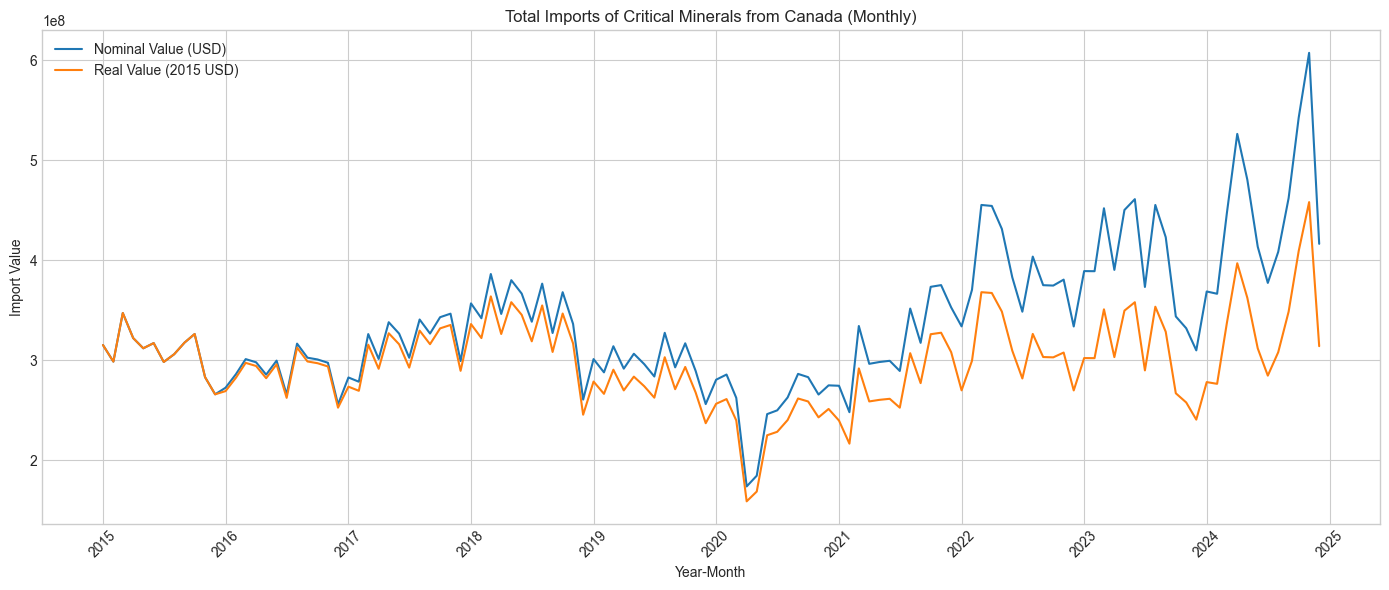


Yearly total imports:


,Value_USD,Real_Trade_Value_2015
Year,,
2015,3709007857,3.709008e+09
2016,3481080794,3.437765e+09
2017,3811539170,3.687278e+09
2018,4184995775,3.942530e+09
2019,3563112789,3.297042e+09
2020,3055002435,2.792507e+09
2021,3810071530,3.326411e+09
2022,4644121239,3.754039e+09
2023,4768943005,3.702596e+09


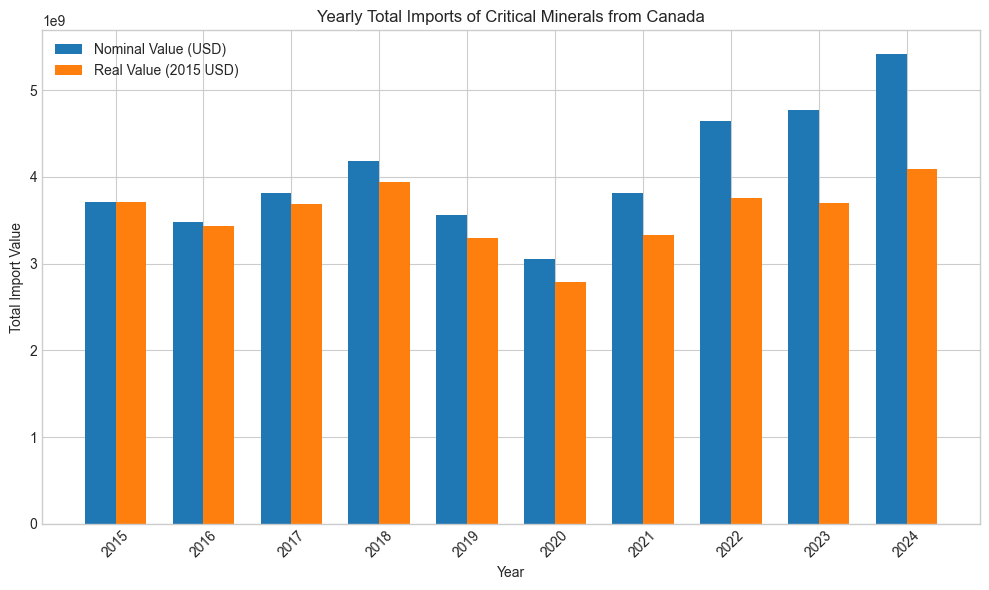


Correlation between monthly nominal and real values: 0.8660

Section 3 Complete: Overall Trade Trends Visualized


In [20]:
import matplotlib.pyplot as plt

# 3.0: Create a proper time index (Year-Month) 

if "YearMonth" not in df.columns:
    df["YearMonth"] = pd.to_datetime(
        dict(year=df["Year"], month=df["Month"], day=1)
    )

# 3.1: Aggregate total imports by month (nominal + real) 

monthly_total = (
    df.groupby("YearMonth")[["Value_USD", "Real_Trade_Value_2015"]]
      .sum()
      .sort_index()
)

print("Monthly total imports (first few rows):")
display(monthly_total.head())


# 3.2: Plot total nominal vs real import values over time 

plt.figure(figsize=(14, 6))
plt.plot(
    monthly_total.index,
    monthly_total["Value_USD"],
    label="Nominal Value (USD)",
)
plt.plot(
    monthly_total.index,
    monthly_total["Real_Trade_Value_2015"],
    label="Real Value (2015 USD)",
)
plt.title("Total Imports of Critical Minerals from Canada (Monthly)")
plt.xlabel("Year-Month")
plt.ylabel("Import Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 3.3: Yearly total imports (nominal vs real) 

yearly_total = (
    df.groupby("Year")[["Value_USD", "Real_Trade_Value_2015"]]
      .sum()
      .sort_index()
)

print("\nYearly total imports:")
display(yearly_total)

plt.figure(figsize=(10, 6))
width = 0.35
years = yearly_total.index.astype(str)

plt.bar(
    x=np.arange(len(years)) - width/2,
    height=yearly_total["Value_USD"],
    width=width,
    label="Nominal Value (USD)",
)
plt.bar(
    x=np.arange(len(years)) + width/2,
    height=yearly_total["Real_Trade_Value_2015"],
    width=width,
    label="Real Value (2015 USD)",
)
plt.xticks(np.arange(len(years)), years, rotation=45)
plt.title("Yearly Total Imports of Critical Minerals from Canada")
plt.xlabel("Year")
plt.ylabel("Total Import Value")
plt.legend()
plt.tight_layout()
plt.show()


# 3.4: Quick diagnostic — correlation between nominal and real 

corr = monthly_total["Value_USD"].corr(monthly_total["Real_Trade_Value_2015"])
print(f"\nCorrelation between monthly nominal and real values: {corr:.4f}")

print("\nSection 3 Complete: Overall Trade Trends Visualized")


Section 4: Commodity Level Analysis

Top 10 commodities by total real import value (2015 USD):


Commodity_Name
Aluminum Plates, Sheets & Strip Over .2mm Thick       1.086686e+10
Electric Storage Batteries, Incl Separators, Parts    1.014693e+10
Aluminum, Unwrought                                   2.578468e+09
Aluminum Bars, Rods And Profiles                      2.204622e+09
Aluminum Structures Nesoi (no Prefab) & Parts Of      1.988927e+09
Aluminum Waste And Scrap                              1.701413e+09
Primary Cells & Batteries, Parts                      1.463429e+09
Aluminum Foil (back Or Not) Nov .2mm Th (ex Back)     8.457505e+08
Nickel Waste And Scrap                                6.629604e+08
Aluminum Tubes And Pipes                              5.910703e+08
Name: Real_Trade_Value_2015, dtype: float64

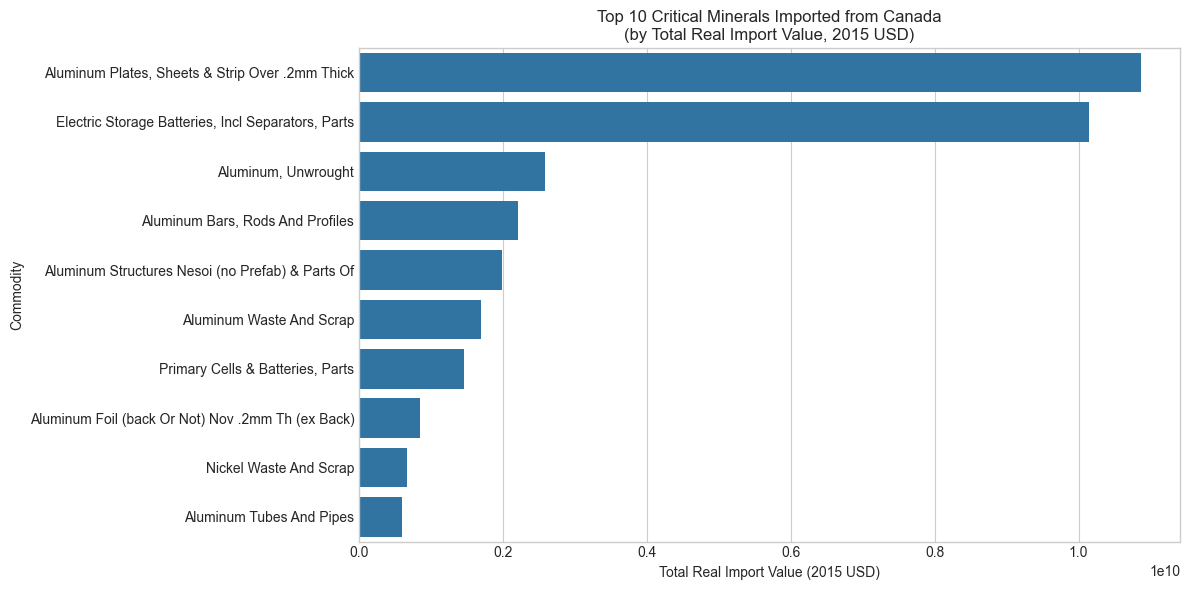


Share of total real imports accounted for by top 5 commodities:


,Percent_of_Total_%
Commodity_Name,
"Aluminum Plates, Sheets & Strip Over .2mm Thick",30.41
"Electric Storage Batteries, Incl Separators, Parts",28.40
"Aluminum, Unwrought",7.22
"Aluminum Bars, Rods And Profiles",6.17
Aluminum Structures Nesoi (no Prefab) & Parts Of,5.57



Top 3 commodities for time-series view: ['Aluminum Plates, Sheets & Strip Over .2mm Thick', 'Electric Storage Batteries, Incl Separators, Parts', 'Aluminum, Unwrought']


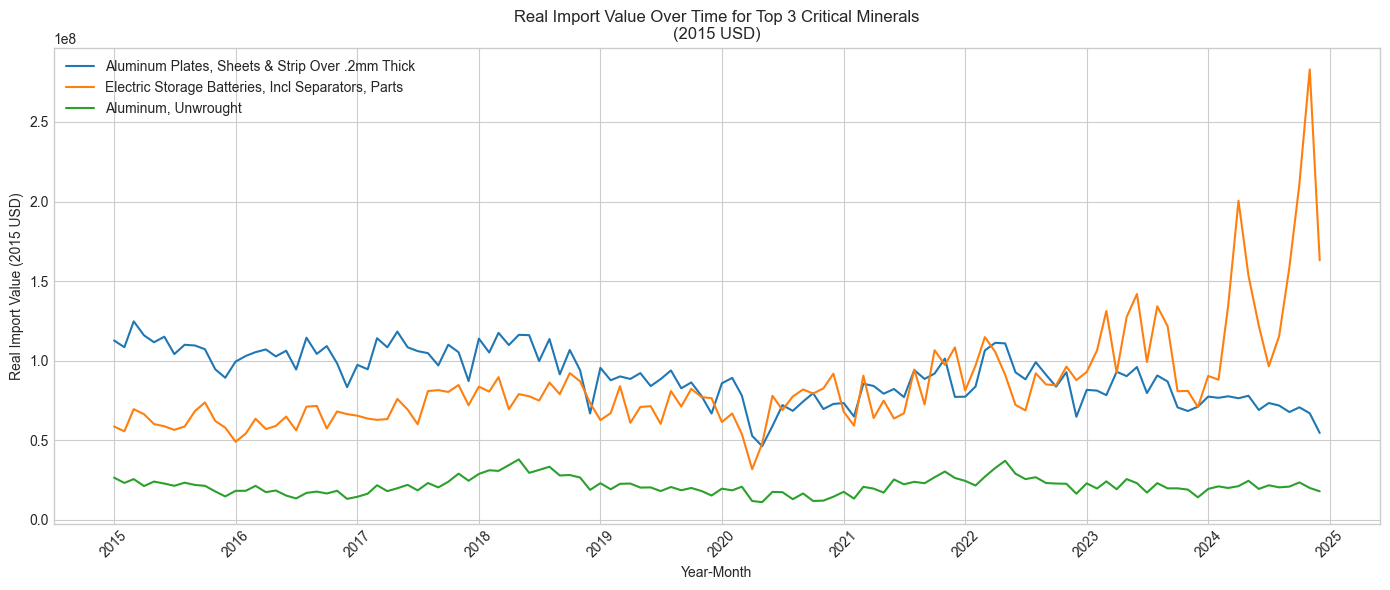


=== Section 4 Complete: Commodity-Level Patterns Explored ===


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")

#  4.0: Makes sure Real_Trade_Value_2015 is numeric and YearMonth is datetime 

df["Real_Trade_Value_2015"] = pd.to_numeric(df["Real_Trade_Value_2015"], errors="coerce")

if "YearMonth" in df.columns:
    df["YearMonth"] = pd.to_datetime(df["YearMonth"])
else:
    df["YearMonth"] = pd.to_datetime(dict(year=df["Year"], month=df["Month"], day=1))


# 4.1: Total real imports by commodity (across all years & districts) 

commodity_totals = (
    df.groupby("Commodity_Name")["Real_Trade_Value_2015"]
      .sum()
      .sort_values(ascending=False)
)

print("Top 10 commodities by total real import value (2015 USD):")
display(commodity_totals.head(10))


# 4.2: Bar chart — Top 10 commodities by real import value 

plt.figure(figsize=(12, 6))
top_n = 10
sns.barplot(
    x=commodity_totals.head(top_n).values,
    y=commodity_totals.head(top_n).index
)
plt.title(f"Top {top_n} Critical Minerals Imported from Canada\n(by Total Real Import Value, 2015 USD)")
plt.xlabel("Total Real Import Value (2015 USD)")
plt.ylabel("Commodity")
plt.tight_layout()
plt.show()


#4.3: Share of total real imports for top commodities 

total_real = commodity_totals.sum()
share_top5 = (commodity_totals.head(5) / total_real * 100).round(2)

print("\nShare of total real imports accounted for by top 5 commodities:")
display(share_top5.to_frame("Percent_of_Total_%"))


# 4.4: Time series of real imports for the top 3 commodities 

top3 = commodity_totals.head(3).index.tolist()
print("\nTop 3 commodities for time-series view:", top3)

plt.figure(figsize=(14, 6))

for com in top3:
    subset = df[df["Commodity_Name"] == com]
    monthly_com = (
        subset.groupby("YearMonth")["Real_Trade_Value_2015"]
              .sum()
              .sort_index()
    )
    plt.plot(monthly_com.index, monthly_com.values, label=com)

plt.title("Real Import Value Over Time for Top 3 Critical Minerals\n(2015 USD)")
plt.xlabel("Year-Month")
plt.ylabel("Real Import Value (2015 USD)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


print("\n Section 4 Complete: Commodity-Level Patterns Explored ")


Section 5: District Level Analysis

Top 10 districts by total real import value (2015 USD):


District
Detroit, MI        1.435089e+10
Ogdensburg, NY     7.422679e+09
Buffalo, NY        6.496921e+09
Seattle, WA        1.962952e+09
Pembina, ND        1.789178e+09
Low Value          1.522799e+09
Great Falls, MT    1.214566e+09
New Orleans, LA    2.585458e+08
Duluth, MN         2.482391e+08
Portland, ME       1.870511e+08
Name: Real_Trade_Value_2015, dtype: float64

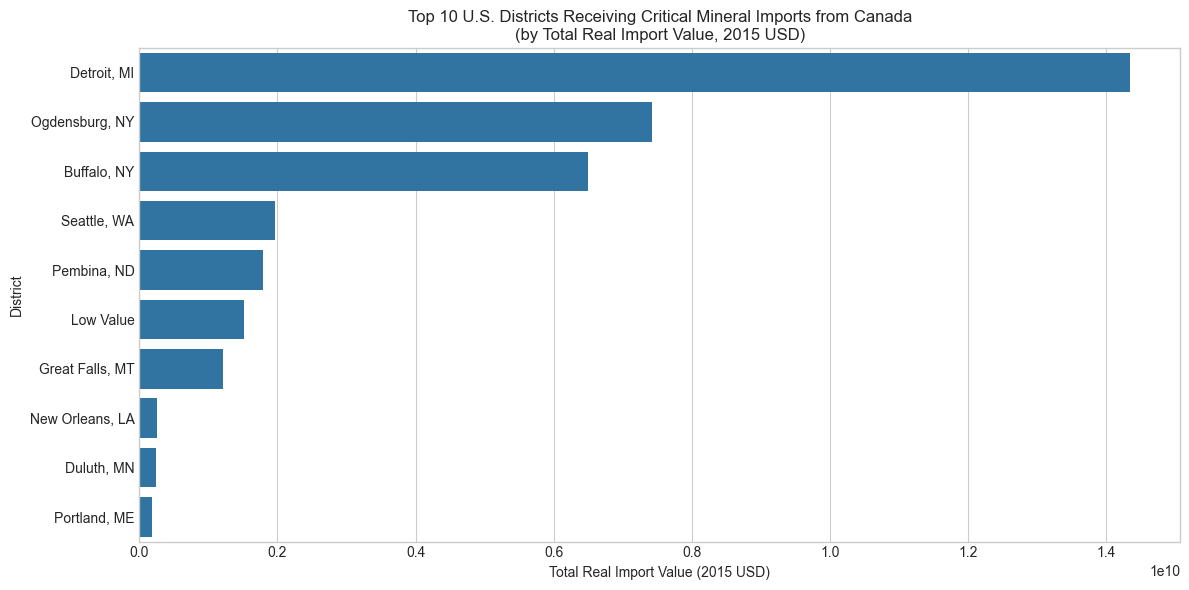


Share of total real imports accounted for by top 5 districts:


,Percent_of_Total_%
District,
"Detroit, MI",40.16
"Ogdensburg, NY",20.77
"Buffalo, NY",18.18
"Seattle, WA",5.49
"Pembina, ND",5.01



Top 3 districts for time-series view: ['Detroit, MI', 'Ogdensburg, NY', 'Buffalo, NY']


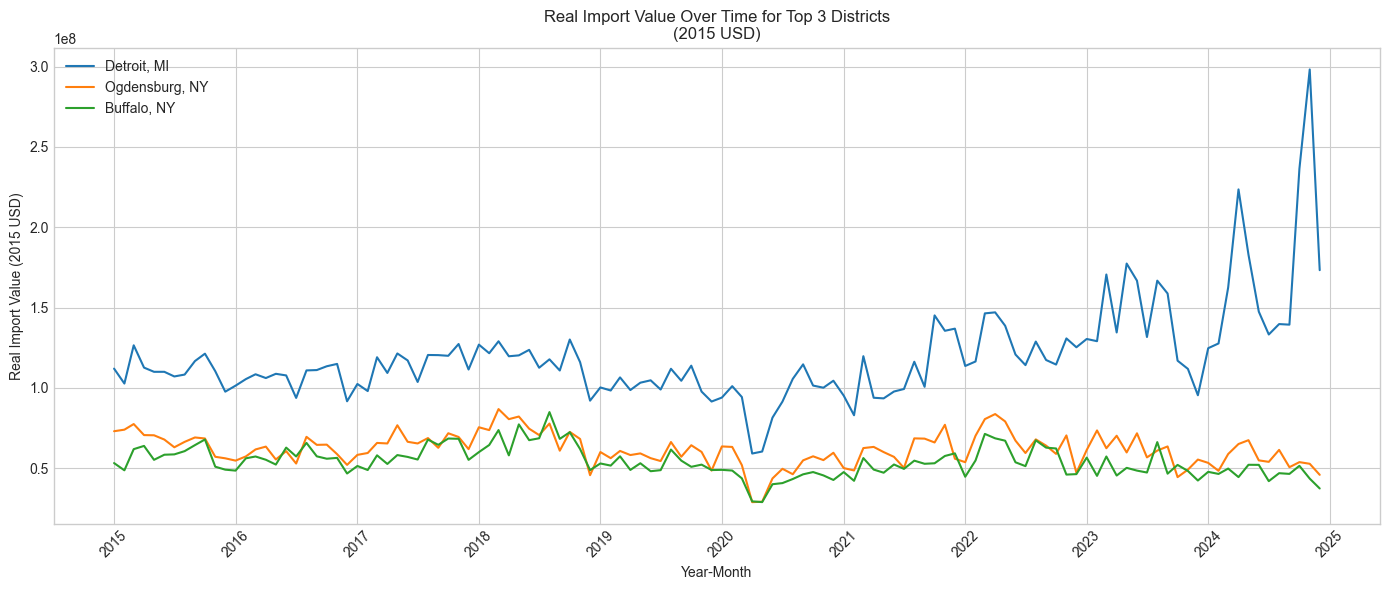


Commodity mix in top district: Detroit, MI

Top 10 commodities in Detroit, MI by real import value:


Commodity_Name
Electric Storage Batteries, Incl Separators, Parts    4.994372e+09
Aluminum Plates, Sheets & Strip Over .2mm Thick       3.783885e+09
Aluminum, Unwrought                                   1.132567e+09
Aluminum Waste And Scrap                              9.225477e+08
Aluminum Structures Nesoi (no Prefab) & Parts Of      6.546815e+08
Aluminum Bars, Rods And Profiles                      6.134583e+08
Primary Cells & Batteries, Parts                      5.958459e+08
Aluminum Foil (back Or Not) Nov .2mm Th (ex Back)     4.195063e+08
Aluminum Tubes And Pipes                              2.908581e+08
Electromagnets, Permanent Magnets Etc & Parts         1.862301e+08
Name: Real_Trade_Value_2015, dtype: float64

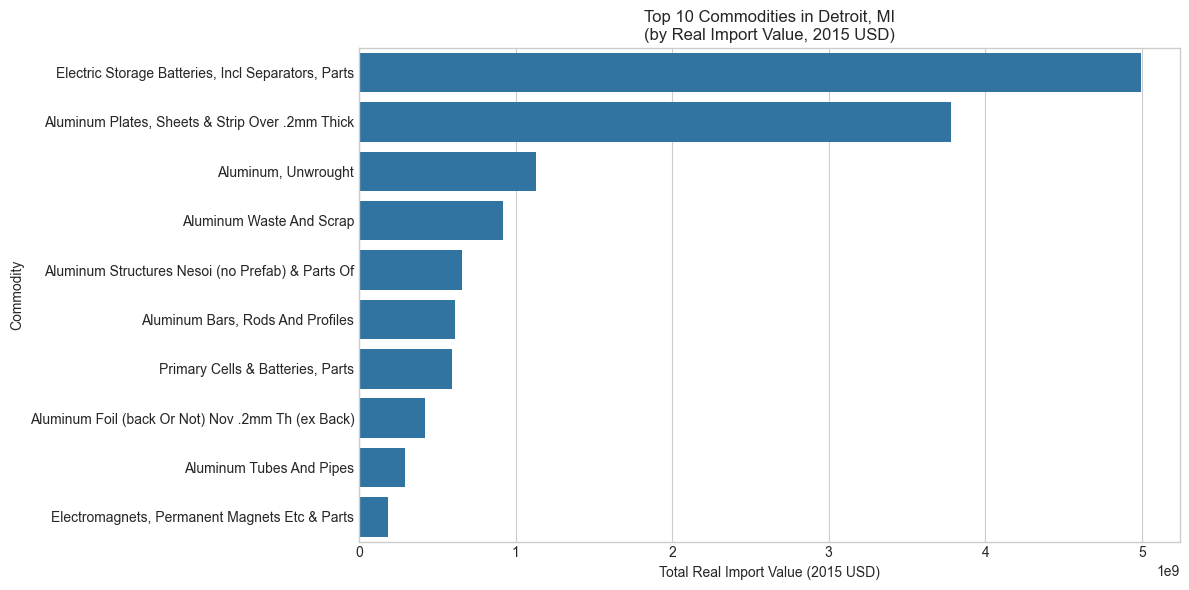


=== Section 5 Complete: District-Level Patterns Explored ===


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")

# 5.0: Ensure Real_Trade_Value_2015 and YearMonth are usable 

df["Real_Trade_Value_2015"] = pd.to_numeric(df["Real_Trade_Value_2015"], errors="coerce")

if "YearMonth" in df.columns:
    df["YearMonth"] = pd.to_datetime(df["YearMonth"])
else:
    df["YearMonth"] = pd.to_datetime(dict(year=df["Year"], month=df["Month"], day=1))


#  5.1: Total real imports by district across all years 

district_totals = (
    df.groupby("District")["Real_Trade_Value_2015"]
      .sum()
      .sort_values(ascending=False)
)

print("Top 10 districts by total real import value (2015 USD):")
display(district_totals.head(10))


#  5.2: Bar chart — Top 10 U.S. districts 

plt.figure(figsize=(12, 6))
top_n = 10
sns.barplot(
    x=district_totals.head(top_n).values,
    y=district_totals.head(top_n).index
)
plt.title(f"Top {top_n} U.S. Districts Receiving Critical Mineral Imports from Canada\n(by Total Real Import Value, 2015 USD)")
plt.xlabel("Total Real Import Value (2015 USD)")
plt.ylabel("District")
plt.tight_layout()
plt.show()


# 5.3: Share of total real imports for top 5 districts 

total_real_district = district_totals.sum()
share_top5_dist = (district_totals.head(5) / total_real_district * 100).round(2)

print("\nShare of total real imports accounted for by top 5 districts:")
display(share_top5_dist.to_frame("Percent_of_Total_%"))


#  5.4: Time series for top 3 districts 

top3_districts = district_totals.head(3).index.tolist()
print("\nTop 3 districts for time-series view:", top3_districts)

plt.figure(figsize=(14, 6))

for dist in top3_districts:
    subset = df[df["District"] == dist]
    monthly_dist = (
        subset.groupby("YearMonth")["Real_Trade_Value_2015"]
              .sum()
              .sort_index()
    )
    plt.plot(monthly_dist.index, monthly_dist.values, label=dist)

plt.title("Real Import Value Over Time for Top 3 Districts\n(2015 USD)")
plt.xlabel("Year-Month")
plt.ylabel("Real Import Value (2015 USD)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 5.5: Commodity mix in the #1 district (what minerals dominate there?) 

top_district = district_totals.index[0]
print(f"\nCommodity mix in top district: {top_district}")

top_dist_subset = df[df["District"] == top_district]

commodity_in_top_dist = (
    top_dist_subset.groupby("Commodity_Name")["Real_Trade_Value_2015"]
                   .sum()
                   .sort_values(ascending=False)
)

print(f"\nTop 10 commodities in {top_district} by real import value:")
display(commodity_in_top_dist.head(10))

plt.figure(figsize=(12, 6))
sns.barplot(
    x=commodity_in_top_dist.head(10).values,
    y=commodity_in_top_dist.head(10).index
)
plt.title(f"Top 10 Commodities in {top_district}\n(by Real Import Value, 2015 USD)")
plt.xlabel("Total Real Import Value (2015 USD)")
plt.ylabel("Commodity")
plt.tight_layout()
plt.show()


print("\nSection 5 Complete: District-Level Patterns Explored ")


Section 6: Seasonality and Time Patterns

Average real import value by month (2015 USD):


Month
1     239666.496156
2     237611.160390
3     272271.227737
4     254129.447078
5     259518.412691
6     256274.168003
7     235670.188458
8     267073.913337
9     257696.750425
10    268589.735838
11    262776.067242
12    227360.852991
Name: Real_Trade_Value_2015, dtype: float64

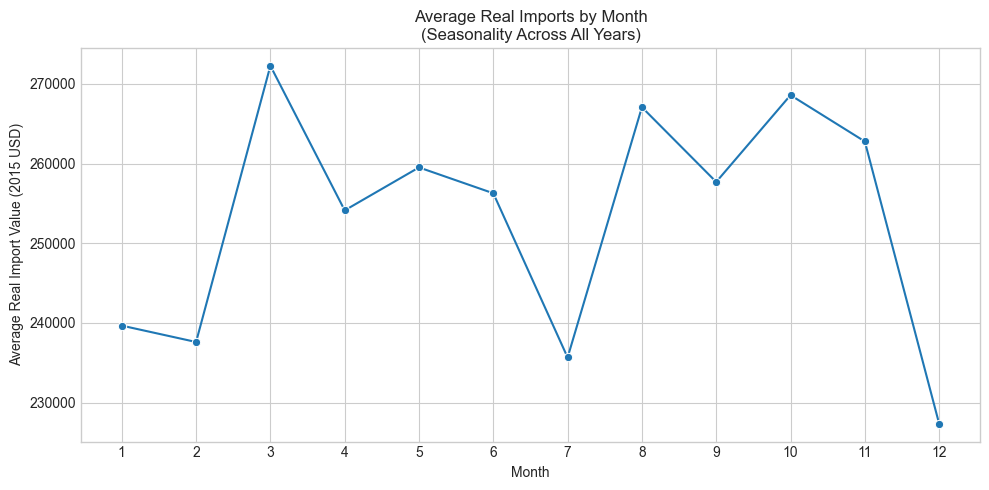


Total real import value by year (2015 USD):


Year
2015    3.709008e+09
2016    3.437765e+09
2017    3.687278e+09
2018    3.942530e+09
2019    3.297042e+09
2020    2.792507e+09
2021    3.326411e+09
2022    3.754039e+09
2023    3.702596e+09
2024    4.085213e+09
Name: Real_Trade_Value_2015, dtype: float64

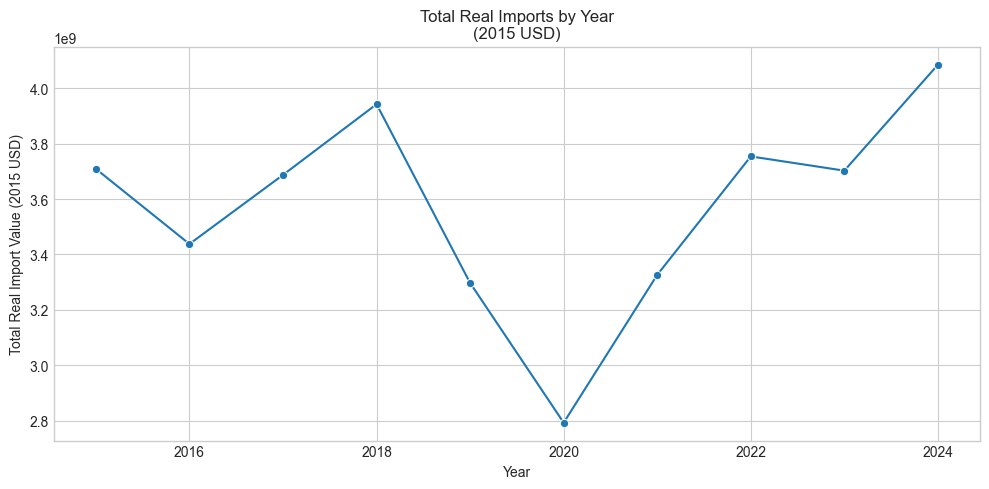

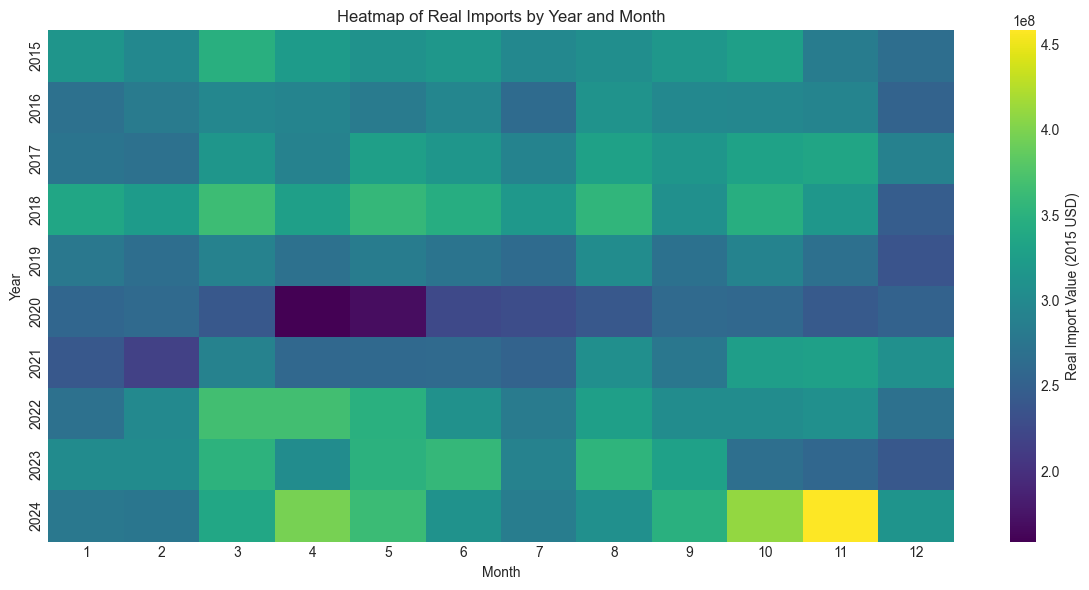


Top 3 commodities for seasonality view: ['Aluminum Plates, Sheets & Strip Over .2mm Thick', 'Electric Storage Batteries, Incl Separators, Parts', 'Aluminum, Unwrought']


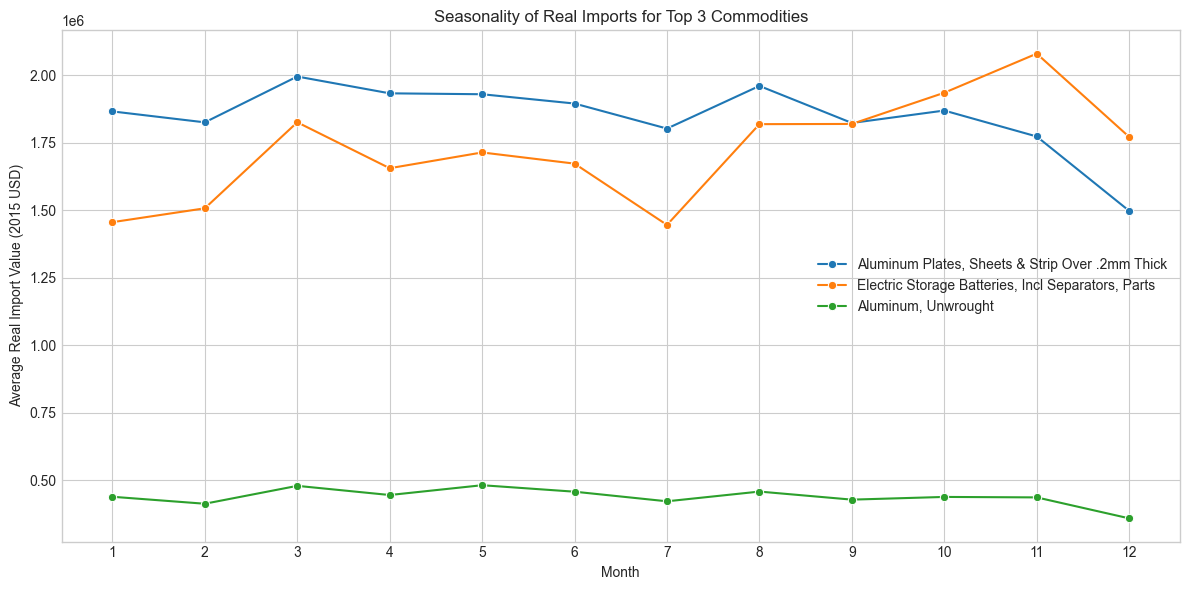


 Section 6 Complete: Seasonality & Time Patterns Explored


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")

# 6.0: Ensure Real_Trade_Value_2015 and YearMonth are ready

df["Real_Trade_Value_2015"] = pd.to_numeric(df["Real_Trade_Value_2015"], errors="coerce")

if "YearMonth" in df.columns:
    df["YearMonth"] = pd.to_datetime(df["YearMonth"])
else:
    df["YearMonth"] = pd.to_datetime(dict(year=df["Year"], month=df["Month"], day=1))


#  6.1: Average real imports by month (overall seasonality) 

monthly_avg = (
    df.groupby("Month")["Real_Trade_Value_2015"]
      .mean()
      .reindex(range(1, 13))
)

print("Average real import value by month (2015 USD):")
display(monthly_avg)

plt.figure(figsize=(10, 5))
sns.lineplot(x=monthly_avg.index, y=monthly_avg.values, marker="o")
plt.title("Average Real Imports by Month\n(Seasonality Across All Years)")
plt.xlabel("Month")
plt.ylabel("Average Real Import Value (2015 USD)")
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()


#  6.2: Total real imports by year (long-run pattern) 

yearly_real = (
    df.groupby("Year")["Real_Trade_Value_2015"]
      .sum()
      .sort_index()
)

print("\nTotal real import value by year (2015 USD):")
display(yearly_real)

plt.figure(figsize=(10, 5))
sns.lineplot(x=yearly_real.index, y=yearly_real.values, marker="o")
plt.title("Total Real Imports by Year\n(2015 USD)")
plt.xlabel("Year")
plt.ylabel("Total Real Import Value (2015 USD)")
plt.tight_layout()
plt.show()


# 6.3: Year × Month heatmap of real trade value 

year_month_pivot = (
    df.groupby(["Year", "Month"])["Real_Trade_Value_2015"]
      .sum()
      .unstack("Month")
      .reindex(columns=range(1, 13))
)

plt.figure(figsize=(12, 6))
sns.heatmap(
    year_month_pivot,
    cmap="viridis",
    cbar_kws={"label": "Real Import Value (2015 USD)"}
)
plt.title("Heatmap of Real Imports by Year and Month")
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.show()


#  6.4: Seasonality for top 3 commodities (optional but powerful) 

# Get top 3 commodities by total real value
commodity_totals = (
    df.groupby("Commodity_Name")["Real_Trade_Value_2015"]
      .sum()
      .sort_values(ascending=False)
)
top3_commodities = commodity_totals.head(3).index.tolist()

print("\nTop 3 commodities for seasonality view:", top3_commodities)

plt.figure(figsize=(12, 6))

for com in top3_commodities:
    subset = df[df["Commodity_Name"] == com]
    monthly_avg_com = (
        subset.groupby("Month")["Real_Trade_Value_2015"]
              .mean()
              .reindex(range(1, 13))
    )
    sns.lineplot(
        x=monthly_avg_com.index,
        y=monthly_avg_com.values,
        marker="o",
        label=com
    )

plt.title("Seasonality of Real Imports for Top 3 Commodities")
plt.xlabel("Month")
plt.ylabel("Average Real Import Value (2015 USD)")
plt.xticks(range(1, 13))
plt.legend()
plt.tight_layout()
plt.show()


print("\n Section 6 Complete: Seasonality & Time Patterns Explored")


Section 7: Volatility (MoM and YoY)

Month-over-Month real change (summary stats):


count    1.399440e+05
mean    -8.161172e+00
std      7.090294e+05
min     -1.139901e+08
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.005893e+08
Name: Diff_Real_From_PrevMonth, dtype: float64

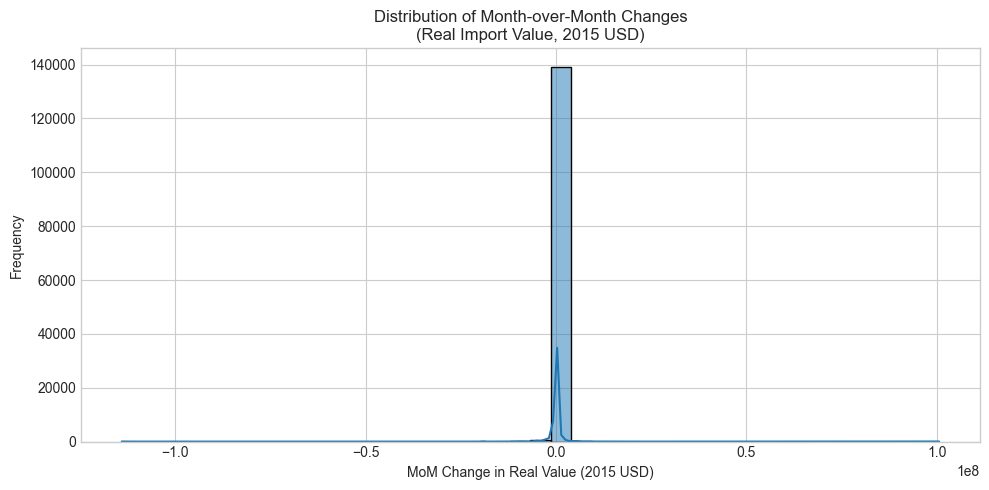


Year-over-Year real change (summary stats):


count    1.270080e+05
mean     2.962059e+03
std      9.534365e+05
min     -2.410335e+07
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.914787e+08
Name: Diff_Real_From_SameMonthPrevYear, dtype: float64

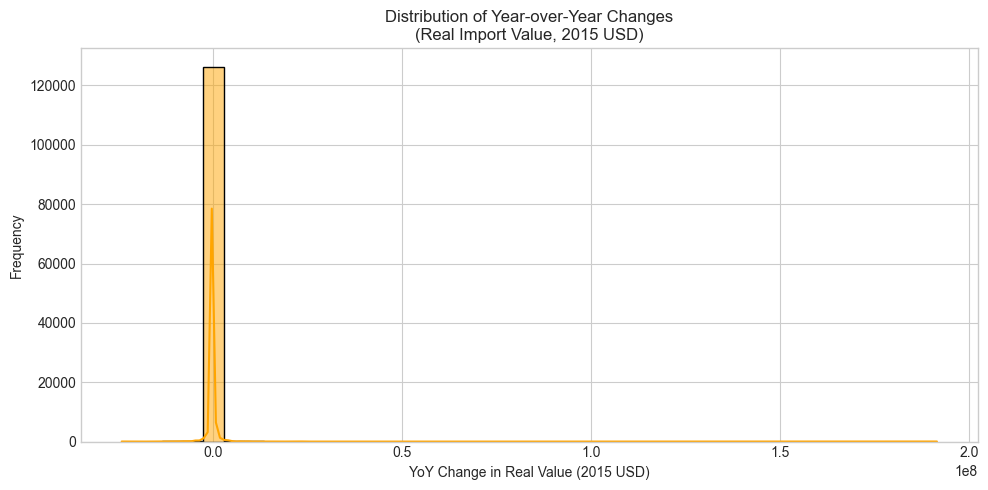


Top 10 most volatile commodities (by MoM std dev of real value):


,MoM_StdDev
Commodity_Name,
"Electric Storage Batteries, Incl Separators, Parts",3.141394e+06
"Aluminum Plates, Sheets & Strip Over .2mm Thick",1.258879e+06
"Aluminum, Unwrought",3.967567e+05
"Primary Cells & Batteries, Parts",3.060459e+05
Aluminum Waste And Scrap,2.809174e+05
Aluminum Structures Nesoi (no Prefab) & Parts Of,2.377994e+05
Nickel Waste And Scrap,2.368795e+05
"Aluminum Bars, Rods And Profiles",2.156154e+05
"Nickle Tubes, Pipes And Tube Or Pipe Fittings",1.695392e+05


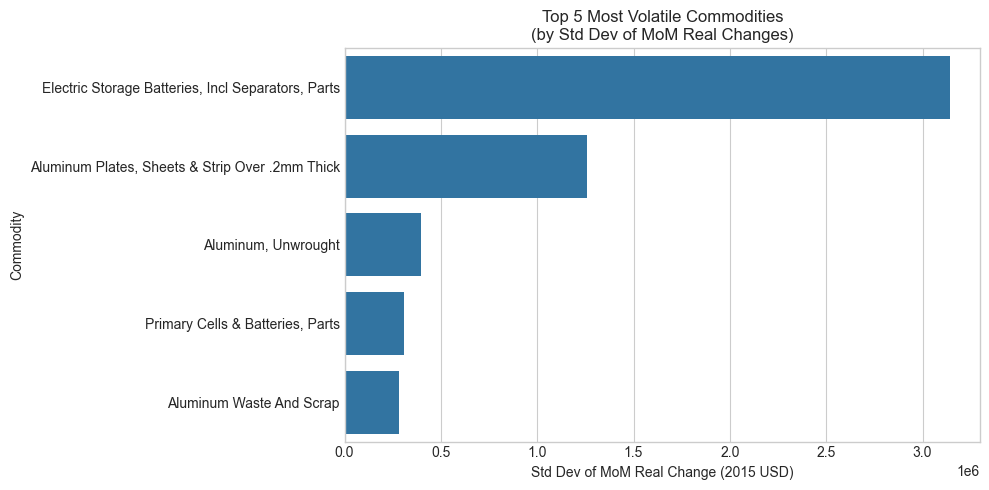


Most volatile commodity (MoM): Electric Storage Batteries, Incl Separators, Parts


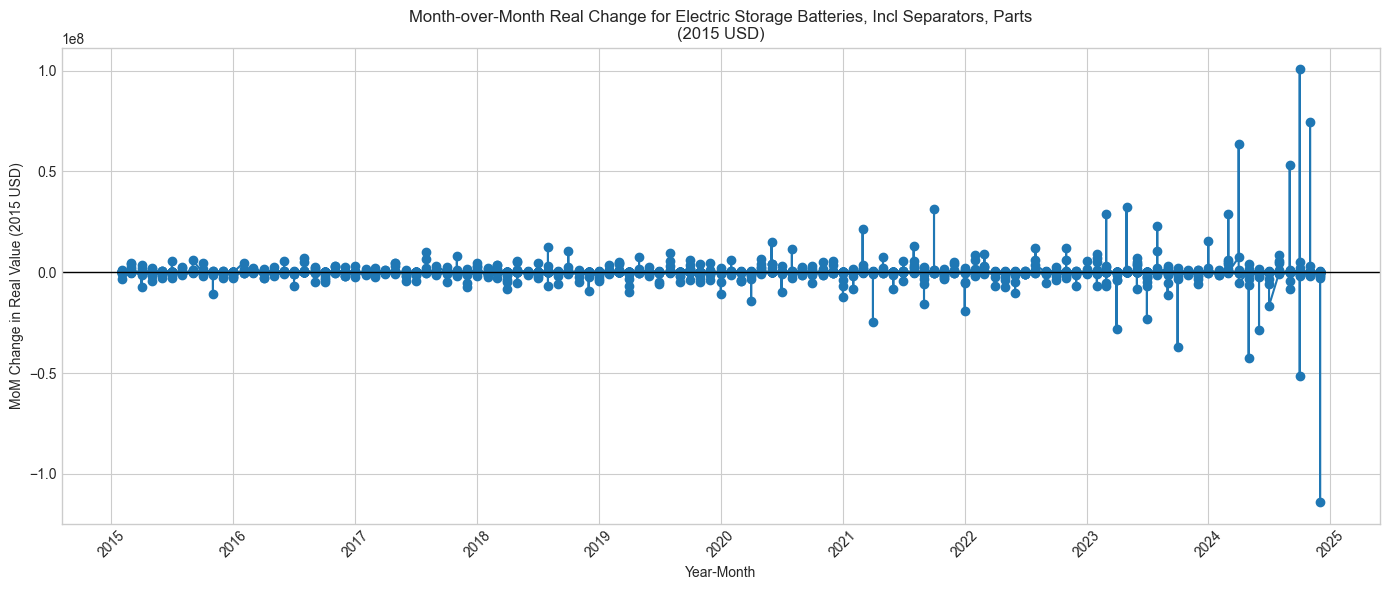


Top 5 most volatile districts (by MoM real change):


,MoM_StdDev
District,
"Detroit, MI",4.236285e+06
"Ogdensburg, NY",1.605678e+06
"Great Falls, MT",1.510237e+06
"Buffalo, NY",1.139306e+06
"Seattle, WA",4.801919e+05


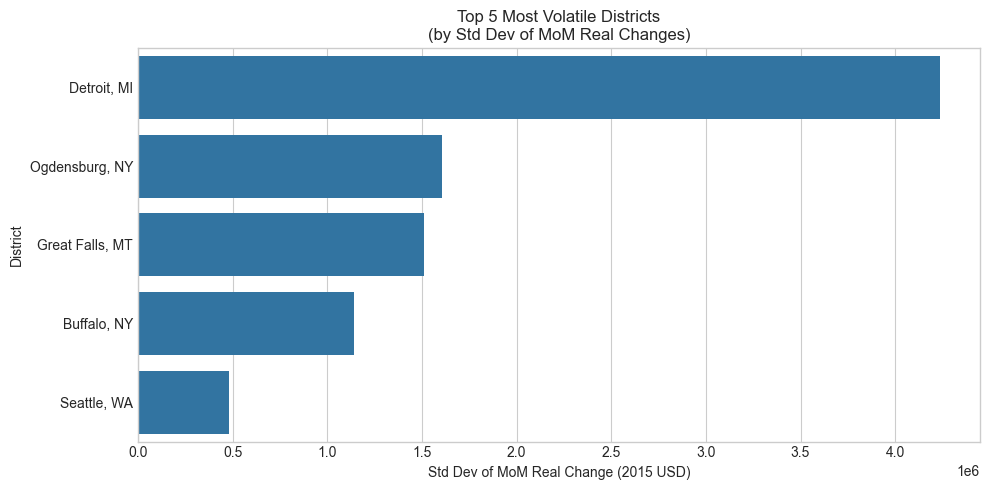


 Section 7 Complete: Volatility & Potential Supply Shocks Explored 


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use("seaborn-v0_8-whitegrid")

# 7.0: Ensure diff columns are numeric 

for col in ["Diff_Real_From_PrevMonth", "Diff_Real_From_SameMonthPrevYear"]:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(",", "", regex=False)
            .str.strip()
        )
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Ensure YearMonth is datetime
df["YearMonth"] = pd.to_datetime(df["YearMonth"])


# 7.1: Overall distribution of MoM real changes 

if "Diff_Real_From_PrevMonth" in df.columns:
    mom = df["Diff_Real_From_PrevMonth"].dropna()

    print("Month-over-Month real change (summary stats):")
    display(mom.describe())

    plt.figure(figsize=(10, 5))
    sns.histplot(mom, bins=40, kde=True)
    plt.title("Distribution of Month-over-Month Changes\n(Real Import Value, 2015 USD)")
    plt.xlabel("MoM Change in Real Value (2015 USD)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
else:
    print("Column Diff_Real_From_PrevMonth not found – skipping MoM analysis.")


# 7.2: Overall distribution of YoY real changes 

if "Diff_Real_From_SameMonthPrevYear" in df.columns:
    yoy = df["Diff_Real_From_SameMonthPrevYear"].dropna()

    print("\nYear-over-Year real change (summary stats):")
    display(yoy.describe())

    plt.figure(figsize=(10, 5))
    sns.histplot(yoy, bins=40, kde=True, color="orange")
    plt.title("Distribution of Year-over-Year Changes\n(Real Import Value, 2015 USD)")
    plt.xlabel("YoY Change in Real Value (2015 USD)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
else:
    print("Column Diff_Real_From_SameMonthPrevYear not found – skipping YoY analysis.")


# --- 7.3: Most volatile commodities based on MoM changes ---

if "Diff_Real_From_PrevMonth" in df.columns:
    # Compute standard deviation of MoM changes per commodity
    mom_volatility = (
        df.groupby("Commodity_Name")["Diff_Real_From_PrevMonth"]
          .std()
          .dropna()
          .sort_values(ascending=False)
    )

    print("\nTop 10 most volatile commodities (by MoM std dev of real value):")
    display(mom_volatility.head(10).to_frame("MoM_StdDev"))

    # Bar plot of top 5 most volatile commodities
    top5_vol = mom_volatility.head(5)

    plt.figure(figsize=(10, 5))
    sns.barplot(
        x=top5_vol.values,
        y=top5_vol.index
    )
    plt.title("Top 5 Most Volatile Commodities\n(by Std Dev of MoM Real Changes)")
    plt.xlabel("Std Dev of MoM Real Change (2015 USD)")
    plt.ylabel("Commodity")
    plt.tight_layout()
    plt.show()

    # 7.4: Time series of MoM changes for the single most volatile commodity 

    most_volatile_com = top5_vol.index[0]
    print(f"\nMost volatile commodity (MoM): {most_volatile_com}")

    vol_subset = df[df["Commodity_Name"] == most_volatile_com].copy()
    vol_subset = (
        vol_subset
        .sort_values("YearMonth")
        [["YearMonth", "Diff_Real_From_PrevMonth"]]
        .dropna()
    )

    plt.figure(figsize=(14, 6))
    plt.plot(
        vol_subset["YearMonth"],
        vol_subset["Diff_Real_From_PrevMonth"],
        marker="o"
    )
    plt.axhline(0, color="black", linewidth=1)
    plt.title(f"Month-over-Month Real Change for {most_volatile_com}\n(2015 USD)")
    plt.xlabel("Year-Month")
    plt.ylabel("MoM Change in Real Value (2015 USD)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

else:
    print("\nSkipping volatility by commodity (MoM column missing).")


# --- 7.5: Volatility by district (optional extra insight) ---

if "Diff_Real_From_PrevMonth" in df.columns:
    dist_volatility = (
        df.groupby("District")["Diff_Real_From_PrevMonth"]
          .std()
          .dropna()
          .sort_values(ascending=False)
    )

    print("\nTop 5 most volatile districts (by MoM real change):")
    display(dist_volatility.head(5).to_frame("MoM_StdDev"))

    plt.figure(figsize=(10, 5))
    sns.barplot(
        x=dist_volatility.head(5).values,
        y=dist_volatility.head(5).index
    )
    plt.title("Top 5 Most Volatile Districts\n(by Std Dev of MoM Real Changes)")
    plt.xlabel("Std Dev of MoM Real Change (2015 USD)")
    plt.ylabel("District")
    plt.tight_layout()
    plt.show()


print("\n Section 7 Complete: Volatility & Potential Supply Shocks Explored ")


Annual inflation rate (as stored in the dataset):


,Inflation_%
Year,
2015,0.12
2016,1.26
2017,2.13
2018,2.44
2019,1.81
2020,1.23
2021,4.70
2022,8.00
2023,4.12


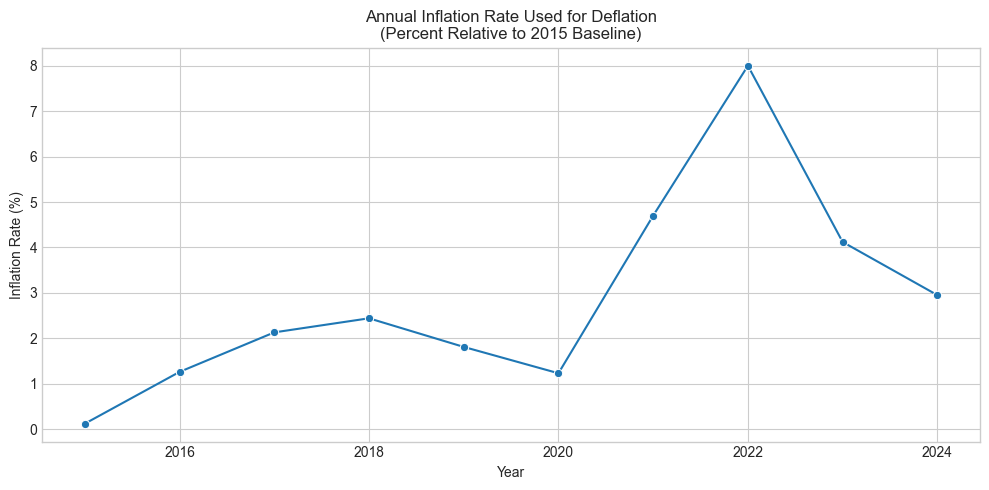


Yearly nominal vs real totals and their ratio:


,Nominal_Value_USD,Real_Value_2015_USD,Real_to_Nominal_Ratio
Year,,,
2015,3709007857,3.709008e+09,1.000000
2016,3481080794,3.437765e+09,0.987557
2017,3811539170,3.687278e+09,0.967399
2018,4184995775,3.942530e+09,0.942063
2019,3563112789,3.297042e+09,0.925326
2020,3055002435,2.792507e+09,0.914077
2021,3810071530,3.326411e+09,0.873057
2022,4644121239,3.754039e+09,0.808342
2023,4768943005,3.702596e+09,0.776398


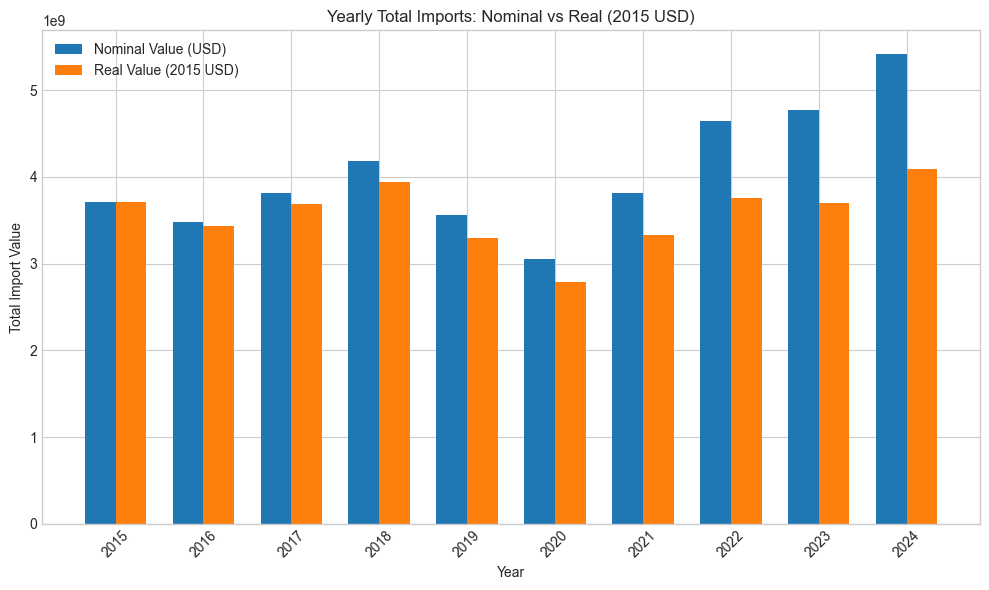

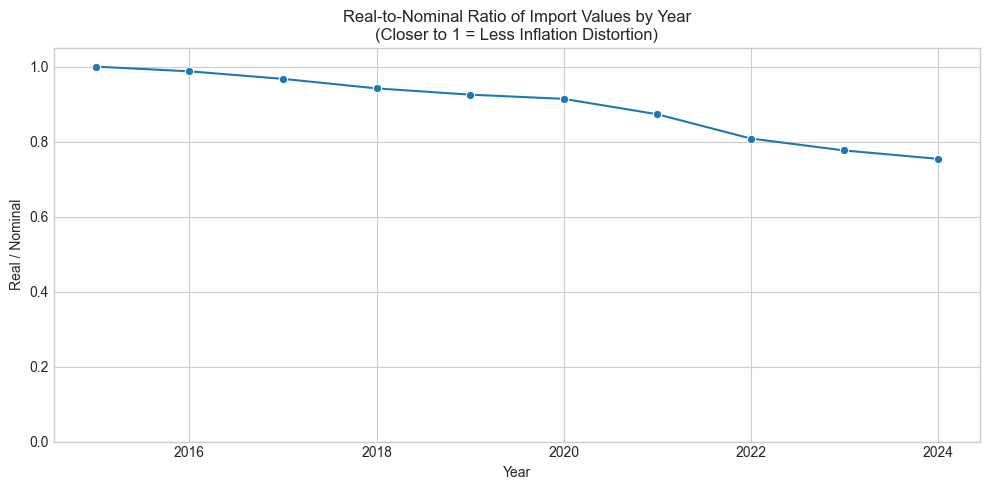


Combined view: inflation vs real-to-nominal ratio:


,Nominal_Value_USD,Real_Value_2015_USD,Real_to_Nominal_Ratio,Inflation_%
Year,,,,
2015,3709007857,3.709008e+09,1.000000,0.12
2016,3481080794,3.437765e+09,0.987557,1.26
2017,3811539170,3.687278e+09,0.967399,2.13
2018,4184995775,3.942530e+09,0.942063,2.44
2019,3563112789,3.297042e+09,0.925326,1.81
2020,3055002435,2.792507e+09,0.914077,1.23
2021,3810071530,3.326411e+09,0.873057,4.70
2022,4644121239,3.754039e+09,0.808342,8.00
2023,4768943005,3.702596e+09,0.776398,4.12


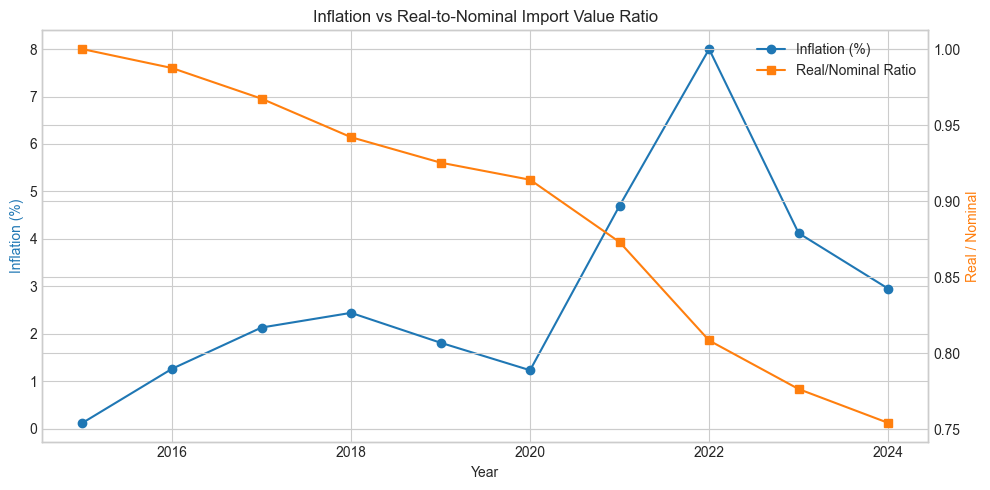


=== Section 8 Complete: Inflation Impact on Trade Values Analyzed ===


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")

# 8.0: Clean & parse inflation column 

if "Inflation_Rate_of_its_year" in df.columns:
    # Convert strings like "1.26%" or "2.5" into numeric percent values
    df["Inflation_Rate_of_its_year"] = (
        df["Inflation_Rate_of_its_year"]
        .astype(str)
        .str.replace("%", "", regex=False)
        .str.replace(",", "", regex=False)
        .str.strip()
    )
    df["Inflation_Rate_of_its_year"] = pd.to_numeric(
        df["Inflation_Rate_of_its_year"], errors="coerce"
    )
else:
    print("Column 'Inflation_Rate_of_its_year' not found.")
    

# 8.1: Annual inflation series

inflation_yearly = (
    df.groupby("Year")["Inflation_Rate_of_its_year"]
      .first()   # should be the same within each year
      .sort_index()
)

print("Annual inflation rate (as stored in the dataset):")
display(inflation_yearly.to_frame("Inflation_%"))


plt.figure(figsize=(10, 5))
sns.lineplot(x=inflation_yearly.index, y=inflation_yearly.values, marker="o")
plt.title("Annual Inflation Rate Used for Deflation\n(Percent Relative to 2015 Baseline)")
plt.xlabel("Year")
plt.ylabel("Inflation Rate (%)")
plt.tight_layout()
plt.show()


# 8.2: Yearly nominal vs real totals + distortion ratio 

yearly_values = (
    df.groupby("Year")[["Value_USD", "Real_Trade_Value_2015"]]
      .sum()
      .sort_index()
      .rename(columns={
          "Value_USD": "Nominal_Value_USD",
          "Real_Trade_Value_2015": "Real_Value_2015_USD"
      })
)

# How much smaller are real values than nominal (due to inflation)?
yearly_values["Real_to_Nominal_Ratio"] = (
    yearly_values["Real_Value_2015_USD"] / yearly_values["Nominal_Value_USD"]
)

print("\nYearly nominal vs real totals and their ratio:")
display(yearly_values)


#  8.3: Plot nominal vs real per year (bar chart) 

plt.figure(figsize=(10, 6))
width = 0.35
years = yearly_values.index.astype(str)
x = np.arange(len(years))

plt.bar(
    x - width/2,
    yearly_values["Nominal_Value_USD"],
    width=width,
    label="Nominal Value (USD)"
)
plt.bar(
    x + width/2,
    yearly_values["Real_Value_2015_USD"],
    width=width,
    label="Real Value (2015 USD)"
)

plt.xticks(x, years, rotation=45)
plt.title("Yearly Total Imports: Nominal vs Real (2015 USD)")
plt.xlabel("Year")
plt.ylabel("Total Import Value")
plt.legend()
plt.tight_layout()
plt.show()


# 8.4: Plot ratio of real to nominal (how much inflation shrinks values) 

plt.figure(figsize=(10, 5))
sns.lineplot(
    x=yearly_values.index,
    y=yearly_values["Real_to_Nominal_Ratio"],
    marker="o"
)
plt.title("Real-to-Nominal Ratio of Import Values by Year\n(Closer to 1 = Less Inflation Distortion)")
plt.xlabel("Year")
plt.ylabel("Real / Nominal")
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


# 8.5: Optional: compare inflation vs real-to-nominal ratio (diagnostic) 

combined_infl = yearly_values.join(
    inflation_yearly.to_frame("Inflation_%"),
    how="left"
)

print("\nCombined view: inflation vs real-to-nominal ratio:")
display(combined_infl)

plt.figure(figsize=(10, 5))
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(
    combined_infl.index,
    combined_infl["Inflation_%"],
    marker="o",
    label="Inflation (%)",
    color="tab:blue"
)
ax2.plot(
    combined_infl.index,
    combined_infl["Real_to_Nominal_Ratio"],
    marker="s",
    label="Real/Nominal Ratio",
    color="tab:orange"
)

ax1.set_xlabel("Year")
ax1.set_ylabel("Inflation (%)", color="tab:blue")
ax2.set_ylabel("Real / Nominal", color="tab:orange")
plt.title("Inflation vs Real-to-Nominal Import Value Ratio")
plt.tight_layout()

# A combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.show()


print("\n Section 8 Complete: Inflation Impact on Trade Values Analyzed ")


Section 9: Key findings 

9.1 Overall Trade Trends

- In nominal terms, U.S. imports of critical minerals from Canada rise from about $3.71B (2015) to about $5.42B (2024).

- In real 2015 dollars, imports move from ≈$3.71B (2015) to ≈$4.09B (2024).

- Real imports grow over the decade, but not nearly as fast as the nominal numbers suggest. You see:
    - A peak around 2018 (~$3.94B),
    - A clear drop in 2019–2020 (~$3.30B → ~$2.79B),
    - Then a recovery and new highs from 2021–2024 (ending at ~$4.09B).

Interpretation:
There is real growth in Canada → U.S. critical mineral imports over time, but it’s interrupted by a noticeable shock in 2019–2020 and then recovers. The big nominal jump hides how much of that is just inflation; the real data show a more modest but steady long-run increase.

9.2 Commodity-Level Concentration and Risk


Top commodities by total real import value (2015 USD):

1. Aluminum Plates, Sheets & Strip Over 0.2mm Thick – ≈ $10.87B

2. Electric Storage Batteries (incl. separators, parts) – ≈ $10.15B

3. Aluminum, Unwrought – ≈ $2.58B

4. Aluminum Bars, Rods and Profiles – ≈ $2.20B

5. Aluminum Structures (non-prefab) & Parts – ≈ $1.99B

These top five alone account for about 77.8% of all real imports:

1. Aluminum plates/sheets: 30.41%

2. Electric storage batteries: 28.40%

3. Aluminum, unwrought: 7.22%

4. Aluminum bars/rods/profiles: 6.17%

5. Aluminum structures & parts: 5.57%

Implications:

- The U.S. is heavily dependent on Canada for a small number of key aluminum products and battery-related goods.

- Any disruption in these specific lines (especially aluminum plates and batteries) would hit a huge fraction of total import value.